# Qcodes example with Teledyne LeCroy 44MXs-B

In [32]:
import qcodes as qc
from qcodes.instrument_drivers.TeledyneLeCroy.TD44MXsB import TD44MXsB
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.data_set import load_by_id
from qcodes.dataset.data_export import get_data_by_id
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.database import initialise_database

In [27]:
import logging
import qcodes.logger as logger
from qcodes.logger import start_all_logging
start_all_logging()

Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\He5user\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import struct

In [3]:
osc = TD44MXsB('osc', 'TCPIP0::192.168.1.7::INSTR')

In [4]:
initialise_database()
qc.new_experiment(name='TD44MXsB_test', sample_name='no_sample')

TD44MXsB_test#no_sample#10@C:\Users\He5user/experiments.db
----------------------------------------------------------

In [80]:
osc.C3.waveform.prepare_waveform()

meas = Measurement()
meas.register_parameter(osc.C3.waveform, paramtype='array')

with meas.run() as datasaver:
    datasaver.add_result((osc.C3.waveform, osc.C3.waveform.get()))
    run_id = datasaver.run_id

Starting experimental run with id: 19


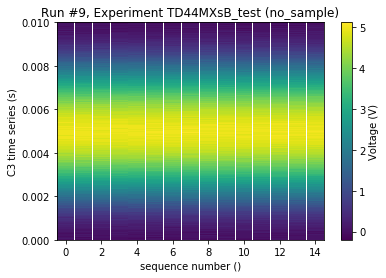

In [78]:
ds = load_by_id(run_id)

title = f"Run #{run_id}, Experiment {ds.exp_name} ({ds.sample_name})"
param_labels = [f'{param.label} ({param.unit})' for param in ds.get_parameters()]
param_names = [param.name for param in ds.get_parameters()]
X, Y, Z = ds.get_data(*param_names)[0]

fig, ax = plt.subplots()
mesh = ax.pcolormesh(X-0.5, Y, Z, rasterized=True)
#ax.axis([X.min(), X.max(), Y.min(), Y.max()])
cax = plt.colorbar(mesh, ax=ax);

ax.set_title(title)
ax.set_xlabel(param_labels[0])
ax.set_ylabel(param_labels[1])
cax.set_label(param_labels[2])

In [80]:
osc.C1.waveform.prepare_waveform()
osc.C2.waveform.prepare_waveform()
osc.C3.waveform.prepare_waveform()

meas = Measurement()
meas.register_parameter(osc.C1.waveform, paramtype='array')
meas.register_parameter(osc.C2.waveform, paramtype='array')
meas.register_parameter(osc.C3.waveform, paramtype='array')

with meas.run() as datasaver:
    datasaver.add_result((osc.C1.waveform, osc.C1.waveform.get()))
    datasaver.add_result((osc.C2.waveform, osc.C2.waveform.get()))
    datasaver.add_result((osc.C3.waveform, osc.C3.waveform.get()))
    run_id = datasaver.run_id

Starting experimental run with id: 19


In [ ]:
ds = load_by_id(run_id)

In [93]:
ds.get_parameters()

[ParamSpec('osc_C1_Seq', 'array', 'sequence number', '', inferred_from=[], depends_on=[]),
 ParamSpec('osc_C1_Time', 'array', 'C1 time series', 's', inferred_from=[], depends_on=[]),
 ParamSpec('osc_C1_waveform', 'array', 'Voltage', 'V', inferred_from=[], depends_on=['osc_C1_Seq', 'osc_C1_Time']),
 ParamSpec('osc_C2_Seq', 'array', 'sequence number', '', inferred_from=[], depends_on=[]),
 ParamSpec('osc_C2_Time', 'array', 'C2 time series', 's', inferred_from=[], depends_on=[]),
 ParamSpec('osc_C2_waveform', 'array', 'Voltage', 'V', inferred_from=[], depends_on=['osc_C2_Seq', 'osc_C2_Time']),
 ParamSpec('osc_C3_Seq', 'array', 'sequence number', '', inferred_from=[], depends_on=[]),
 ParamSpec('osc_C3_Time', 'array', 'C3 time series', 's', inferred_from=[], depends_on=[]),
 ParamSpec('osc_C3_waveform', 'array', 'Voltage', 'V', inferred_from=[], depends_on=['osc_C3_Seq', 'osc_C3_Time'])]

In [100]:
title = f"Run #{run_id}, Experiment {ds.exp_name} ({ds.sample_name})"
XYZ_param_names = ('osc_C1_Seq','osc_C3_waveform','osc_C2_waveform')
XYZ_params = [param for param in ds.get_parameters() if (param.name in XYZ_param_names)]
XYZ_param_labels = [f'{param.label} ({param.unit})' for param in XYZ_params]

In [99]:
X = ds.get_data('osc_C1_Seq')[0][0]
Y = ds.get_data('osc_C3_waveform')[2][0]
Z = ds.get_data('osc_C2_waveform')[1][0]
X,Y,Z

(array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 2,  2,  2, ...,  2,  2,  2],
        ...,
        [13, 13, 13, ..., 13, 13, 13],
        [14, 14, 14, ..., 14, 14, 14],
        [15, 15, 15, ..., 15, 15, 15]]),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.06641869],
        [ 0.        ,  0.        , -0.06641869, ...,  0.06641869,
          0.        ,  0.        ],
        [ 0.        ,  0.06641869,  0.        , ...,  0.13283737,
          0.        ,  0.06641869],
        ...,
        [ 0.06641869, -0.06641869,  0.        , ...,  0.        ,
          0.06641869,  0.        ],
        [ 0.        , -0.13283737,  0.13283737, ...,  0.06641869,
         -0.06641869, -0.06641869],
        [ 0.06641869,  0.06641869,  0.        , ...,  0.        ,
          0.06641869, -0.06641869]]),
 array([[-0.00166047, -0.00332093, -0.00664187, ..., -0.00332093,
         -0.00664187, -0.0049814 ],
        [-0.00664187, 

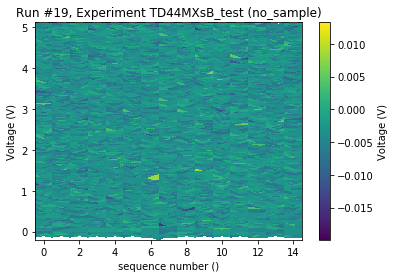

In [101]:
fig, ax = plt.subplots()
mesh = ax.pcolormesh(X-0.5, Y, Z, rasterized=True)
#ax.axis([X.min(), X.max(), Y.min(), Y.max()])
cax = plt.colorbar(mesh, ax=ax);

ax.set_title(title)
ax.set_xlabel(XYZ_param_labels[0])
ax.set_ylabel(XYZ_param_labels[1])
cax.set_label(XYZ_param_labels[2])